## Proyecto 1 - Etapa 1

### Integrantes

- Nicolas Diaz Montaña / n.diaz9 / 202021006
- Sebastian Casanova
- Julio Peña
   

## 1. Importacion de librerias  y Carga de Datos

In [1]:
## %pip install num2words
## %pip install ydata-profiling
## %pip install pattern
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import num2words
import re, unicodedata, inflect
import nltk
from pattern.es import parse, split
from gensim.models import Word2Vec
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from ydata_profiling import ProfileReport

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt

In [5]:
PRINT_RECALL = "Recall:"
PRINT_PRECISION = "Precision:"
PRINT_F1 = "F1:"

In [6]:
# Configuring pandas to show all cell content
pd.set_option("display.max_colwidth", None)

In [7]:
# Downloading stopwords
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\granj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\granj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [16]:
reviews_df = pd.read_csv(r"C:\Users\granj\Documents\Universidad de los Andes\Bi\Proyecto-1\data\tipo1_entrenamiento_estudiantes.csv")

#### 1.1 Entendimiento de Datos

In [17]:
reviews_df.shape

(7875, 2)

In [18]:
reviews_df.sample(5)

,Review,Class
6460,"El hotel es excelente y su ubicación espectacular pero todo eso pierde valor por la mala experiencia que tuvimos respecto a la habitación que nos dieron. Somos una pareja con dos hijos de 10 y 5 años y reservamos a través de agencia de viaje con más de 6 meses de anticipación una habitación por tres noches. Luego de muchas horas de viaje arribamos al hotel el sábado 30 de junio sobre las 21:30 horas y grande fue nuestra sorpresa cuando abrimos la puerta de la habitación y tenía dos camas individuales y una cuna de bebé... para 4 personas. Nos quejamos y nos dijeron que en el hotel no habían habitaciones para 4 personas aunque habían varias familias similares a la nuestra (dos adultos y dos niños). La solución, si puede llamarse así, fue retirar la desubicada cuna y poner una…",2
2229,"Todo bien, pero me cargaron doble la estancia, no quisieron regresarme de inmediato a mi tarjeta de credito el doble cobro y ahora estoy sujeto a los reclamos y tramites con el banco para recuperar el doble cobro.",3
1494,"MI experiencia en general fue satisfactoria, solo hubo un area de oportunidad respecto al olor de coladeras de mi habitación el cual se los hice saber para que mejoren, de ahi en fuera el personal en general fue muy amable y servicial.",5
4548,"Nuestra familia no una mañana de visita guiada. Las ruinas están muy bien conservadas. Un par de pegas el precio de la entrada es irrisorio en comparación a Coba y Tulum. Que siendo residentes, pero a mitad de su todavía casi el triple de algunos de los otros lugares de interés. El otro inconveniente es que los vendedores que están en cada ruta en ambos lados. Es tan triste ver especialmente para este ser como un monumento nacional por ellos a gritos que constantemente. Sin duda creo que este comercialismo lleva lejos de estas ruinas precioso. Ellos tienen suficiente para la admisión ¿por qué cientos de vendedores por todas partes. Por eso Coba es mi primera elección para las ruinas en la zona, gran precio no hay vendedores.",3
7640,"Lo positivo, un lugar para conocer mas de la biodiversidad del país. Lo mejor es el tiburonario, lo cual no deja de ser impresionante, el estar tan cerca de estas especies. Ya había visitado el sitio cuando recién inició y de las diferencias significantes están el delfinario y lo mas reciente, los pingüinos de humbolt, ambas hermosas criaturas que vale la pena ver. Lo negativo fue encontrar el lugar un poco descuidado, creo con un poco mas de mantenimiento levantaría mucho. En cuanto al área de pingüinos, no soy experto pero se me hizo muy reducido para la cantidad que son. Aun así es recomendable el visitarlo.",3


In [19]:
reviews_df["Class"].value_counts(dropna=False, normalize=True)

Class
5    0.298413
4    0.250286
3    0.199111
2    0.148952
1    0.103238
Name: proportion, dtype: float64

In [20]:
textos = reviews_df.copy()
textos['Conteo'] = [len(x) for x in textos['Review']]
textos['Moda'] = [pd.Series(x).value_counts().index[0] for x in textos['Review']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Review']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(textos)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
reviews_df["Review"] = reviews_df["Review"].astype(str)

## 2. Preparacion de Datos

Para poder empezar el pre-procesamiento de los datos es recomendable realizar las siguientes etapas: Limpieza de los datos, tokenizar y normalizar.

### 2.1. Limpieza de los datos

Para empezar toca eliminar y remplazar cualquier ruido que nos puede generar informacion poco relevante, o conflictos en el peor de los casos, a la hora de hacer el analisis de texto, tales como: 
* Palabras que no esten en ASCII, ya que como el texto esta en español pueden haber tildes.
* Palabras que tengan mayusculas, para que el programa no se confunda y tome dos palabras que sean iguales pero las tome como diferentes por tener mayusculas.
* Puntuacion, ya que estas no se cuenta como palabras en si y no nos daria informacion relevante,
* Reseñas repetidas, para que no genere sesgos o redundancia en el analisis.
* Palabras Stop, para eliminar palabras comunes que generan ruido en los datos y que no aportan al análisis.

In [22]:
def remove_non_ascii(words):
    """Remueve las palabras que no sean ASCII de una lista de palabras 
    tokenizadas"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convierte todos los caracteres de una lista de palabras 
    tokenizadas a minusculas"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Elimina la puntuacion de una lista de palabras 
    tokenizadas"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Reemplaza los números de una lista de palabras tokenizadas por una representación textual"""
    new_words = []
    for word in words:
        try:
            if word.isdigit():
                new_word = num2words(int(word), lang='es')
                new_words.append(new_word)
            else:
                new_words.append(word)
        except ValueError:
            # En caso de que el valor no sea un dígito, simplemente añadir la palabra original
            new_words.append(word)
    return new_words
    
def remove_stopwords(words):
    """Elimina las 'stopwords' de una lista de palabras 
    tokenizadas"""
    return [word for word in words if word not in stop_words]

def preprocessing(words):
    words = to_lowercase(words)
    # words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [23]:
reviews_df.duplicated().any()

True

In [24]:
reviews_df_final = reviews_df.drop_duplicates()

In [25]:
reviews_df_final.duplicated().any()

False

### 2.2. Normalizacion

Toca tomar en cuenta que hay varios aspectos de la normalizacion que pueden hacer parte de la limpieza de datos, y viceversa. En nuestro caso, simplemente se hara lemmatizacion debido a que tiene en cuenta el contexto y la gramática del texto para encontrar la forma basica de una palabra. Esto ayuda a preservar el significado original de las palabras, lo que puede ser crucial para comprender las opiniones expresadas en las reseñas. Ademas, de que ayuda a reducir la variabilidad léxica y resaltar de manera más efectiva las características de los lugares turísticos.

In [26]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = nltk.stem.SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = nltk.WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = lemmatize_verbs(words)
    words = stem_words(words)
    return words

### 2.3. Tokenizacion

Se realiza la tokenizacio dado a que ayuda a capturar la estructura el significado y caracteristicas relevantes del texto, lo cual es nos ayuda en el contexto del  negocio dado a que queremos evidenciar las caracteristicas mas relevantes de los lugares turisticos. Separar las frases en palabras por medio de apply y una función que tokeniza. Una vez toquenizado se aplican las funciones de limpieza de datos y normalizacion. 

In [27]:
reviews_df_final["Review"] = reviews_df_final["Review"].apply(word_tokenize).apply(preprocessing).apply(normalize).apply(" ".join)
reviews_df_final.sample(5)

,Review,Class
3782,ser artesanal ser feo si verd quier deleitart buen pizz lug not merc met product normal baj calid sol lug vend adem mejorm,1
1507,cre tem principal hotel marc si 5 estrell asi expect mas alta realid siempr va ser problem person justific calid inferior dic 5 estrell estrell cub despu hab 5 haban pued dec injust cub autent cinc estrell hotel cuban exist exterior parec genial jardin estan bien cuid buffet desayun buen tortill tortit estacion fresc much varied bienven cal neces medic buen baj cost embarg hech agu cortesi,2
3490,manzan zocal bien construidon iglesi arquitectur bastant espectacul,4
5112,part buen fot edifici arruin llev sol pierd irland acerc ubic frent mar llev masc nariz tan enferm moment pes vapor entras direct ellaun vez mas viej haban decepcion si busc comprend histori leer cas ningun habl ingles muse galeri arte ellosn especial skip pas haban oest,3
410,encant pas seman dentr ciud amurall facil camin lad disfrut precios edifici color estil perfect fotograf nivel pierd puest sol vist 6a plant hotel movich,5


### 2.4. Análisis y ultimos ajustes

#### 2.4.1 Clase 1

In [28]:
data_class_1 = reviews_df_final.loc[reviews_df_final['Class']==1]


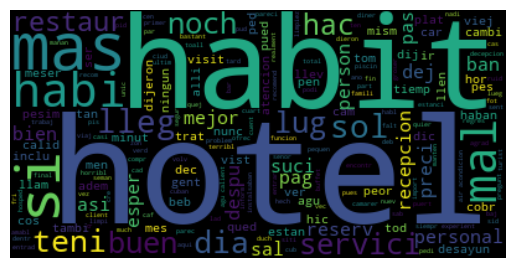

In [29]:
wc = WordCloud().generate("".join(data_class_1["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.2 Clase 2

In [30]:
data_class_2 = reviews_df_final.loc[reviews_df_final['Class']==2]

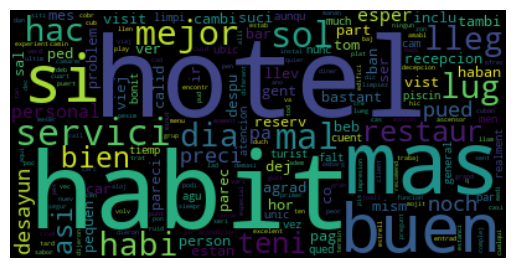

In [31]:
wc = WordCloud().generate("".join(data_class_2["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.3 Clase 3

In [32]:
data_class_3 = reviews_df_final.loc[reviews_df_final['Class']==3]

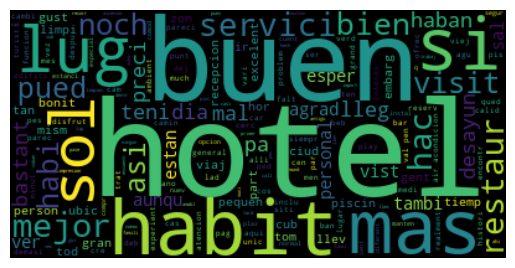

In [33]:
wc = WordCloud().generate("".join(data_class_3["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.4 Clase 4

In [34]:
data_class_4 = reviews_df_final.loc[reviews_df_final['Class']==4]

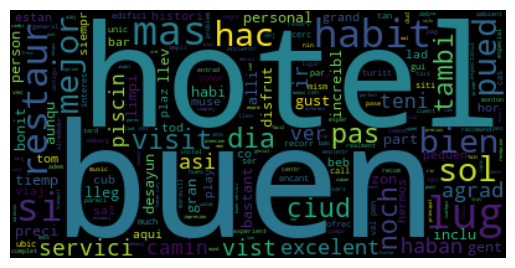

In [35]:
wc = WordCloud().generate("".join(data_class_4["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.5 Clase 5

In [36]:
data_class_5 = reviews_df_final.loc[reviews_df_final['Class']==5]

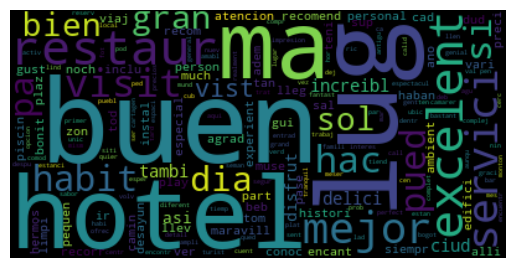

In [37]:
wc = WordCloud().generate("".join(data_class_5["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.4.6 Ajustes finales

In [105]:
stop_words.append("si")
#stop_words.append("ser")
#stop_words.append("alli")
#stop_words.append("cada")
#stop_words.append("ir")
#stop_words.append("do")
#stop_words.append("asi")
#stop_words.append("buen")
stop_words.append("hotel")
stop_words.append("habit")
stop_words.append("mas")
stop_words.append("lug")
#stop_words.append("tambien")

In [106]:
reviews_df_final["Review"] = reviews_df_final["Review"].apply(word_tokenize).apply(remove_stopwords).apply(" ".join)

In [107]:
reviews_df_final.sample(5)

,Review,Class
1629,excelent estadi excelent instal ampli limpi ampli comod limpi cam almoh riquisim ban limpi atencion personal atent amabl,5
7037,tard noch pued visit apur aunqu vendedor ambul atosig igual pued disfrut panoram imperd cartagen,4
2323,precios encant puebl terraz precios ubic excelent restaur genial com casi tod com 3 dias puebl impresion servici impec ah olvid arte tod part sencill impresion mejor encant aloj cualqui,5
2749,ocasion estab haban plaz top vid ruid music centr neuralg tod activ ahor vuelt aburr cuadr,2
1029,fidel che pap person signific atend gent aqui necesit celebr revolucion ten papal tan cualqu,4


## 3. Entrenamiento

In [108]:
# The param 'stratify' is useful to guarantee label proportions on train and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews_df_final[["Review"]], reviews_df_final["Class"], test_size=0.3, stratify=reviews_df_final["Class"], random_state=1)

In [109]:
X_train_tokens = [nltk.word_tokenize(text) for text in X_train]
X_test_tokens = [nltk.word_tokenize(text) for text in X_test]

In [110]:
X_train.shape, X_test.shape

((5462, 1), (2342, 1))

In [111]:
pd.Series(y_train).value_counts(normalize=True)

Class
5    0.299707
4    0.251556
3    0.199011
2    0.148663
1    0.101062
Name: proportion, dtype: float64

In [112]:
pd.Series(y_test).value_counts(normalize=True)

Class
5    0.299744
4    0.251494
3    0.198975
2    0.148591
1    0.101196
Name: proportion, dtype: float64

## 4.  Vectorizacion de Texto

In [113]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [114]:
X_bow = bow.fit_transform(X_train["Review"])

In [115]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 12248


In [116]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [117]:
X_tfidf = tfidf.fit_transform(X_train["Review"])

In [118]:
print("Vocabulary size:", len(tfidf.vocabulary_))

Vocabulary size: 12248


## 5. Modelos y Algoritmos

### 5.1. Modelo Random Forest en conjunto con TF-IDF (Nicolas Diaz Montaña)

El modelo TF-IDF (Term Frequency-Inverse Document Frequency) es una técnica utilizada en el procesamiento de lenguaje natural (NLP) para analizar la importancia de una palabra en un documento en relación con una colección de documentos. Es comúnmente utilizado en tareas de minería de texto, recuperación de información y clasificación de texto. En el contexto del negocio, TF-IDF puede ser utilizado para identificar las palabras clave y características más relevantes que contribuyen a la evaluación de un lugar turístico.

In [119]:
tfidf_model = RandomForestClassifier(random_state=3)

In [120]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

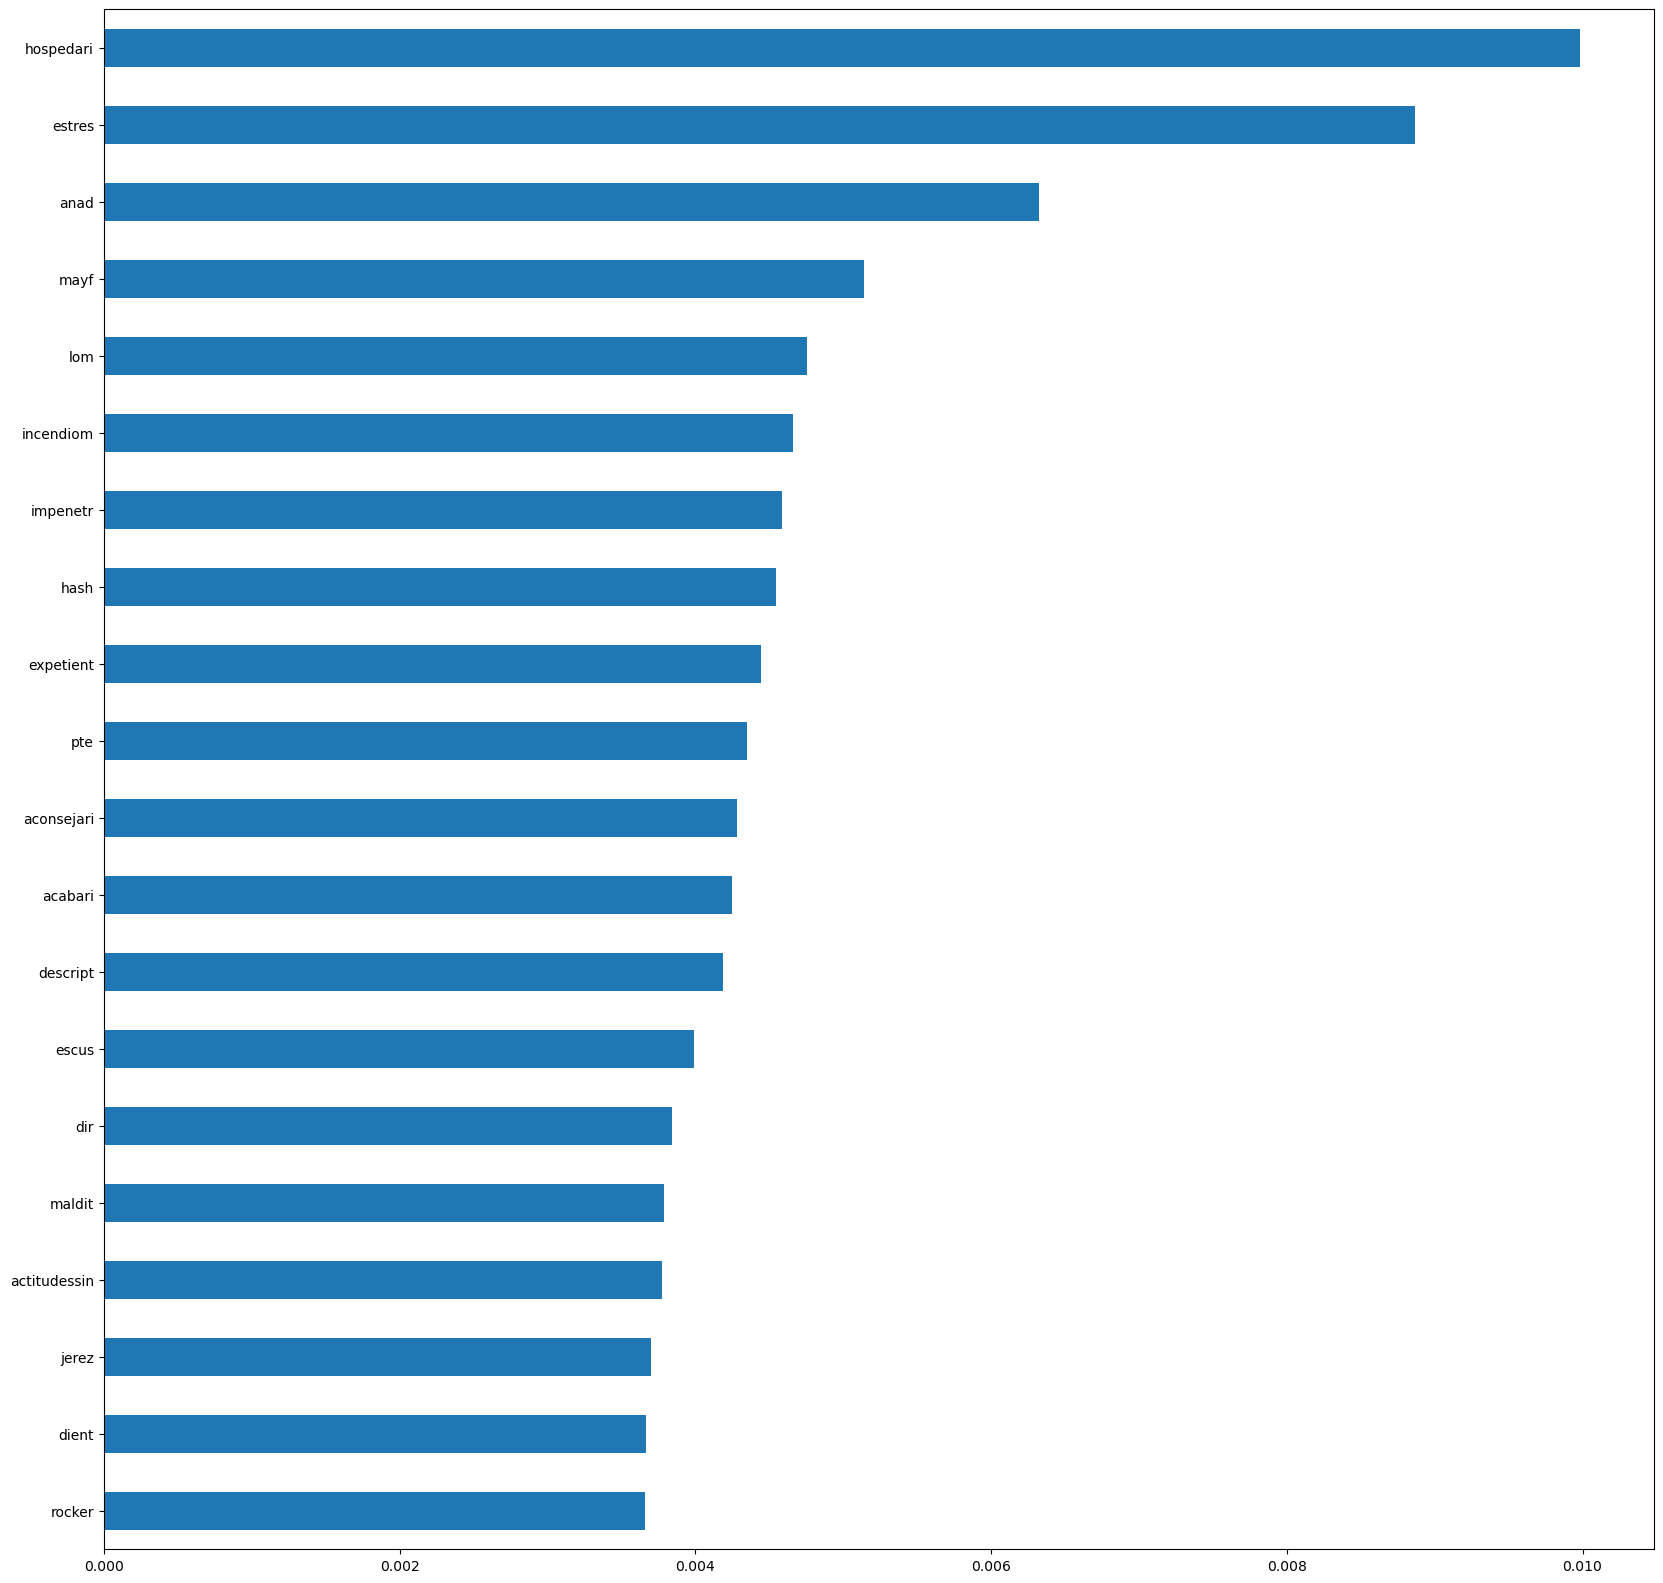

In [121]:
pd.Series(tfidf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(20, 20))

In [122]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 255.26


In [123]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test["Review"]))

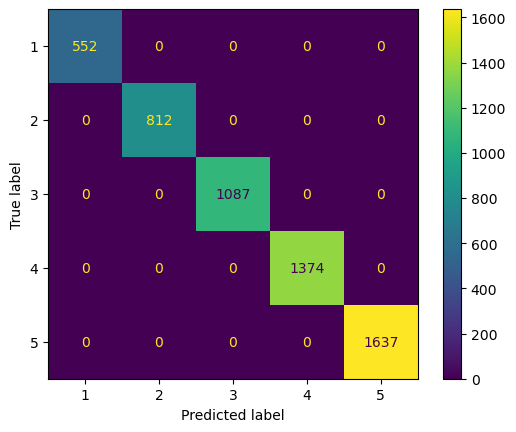

In [124]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

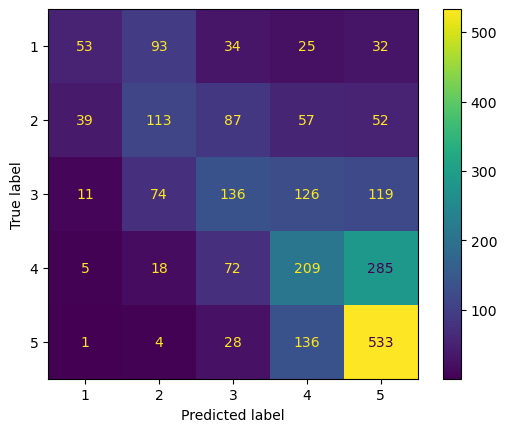

In [125]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [126]:
print(PRINT_PRECISION, precision_score(y_train, y_train_tfidf_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_tfidf_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_tfidf_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [127]:
print(PRINT_PRECISION, precision_score(y_test, y_test_tfidf_predict, average="weighted"))  
print(PRINT_RECALL, recall_score(y_test, y_test_tfidf_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_tfidf_predict, average="weighted"))

Precision: 0.43213073275332975
Recall: 0.4457728437233134
F1: 0.425928122191051


### 5.2. Modelo BoW (Julio  Alexander Peña Tovar)

Bag of words (BoW) es una técnica de procesamiento de texto que convierte documentos de texto en vectores numéricos, ignorando el orden de las palabras. Primero, construye un vocabulario  a partir de todas las palabras diferentes en nuestro conjunto de datos. Luego, para cada review en nuestra conjunto de datos, cuenta la frecuencia de cada palabra  y construye un vector donde cada elemento representa el número de ocurrencias de una palabra específica en la review. Esto resulta en una matriz donde cada fila representa una review y cada columna representa una palabra única del vocabulario.

In [128]:
bow_model = RandomForestClassifier(random_state=2)

In [129]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

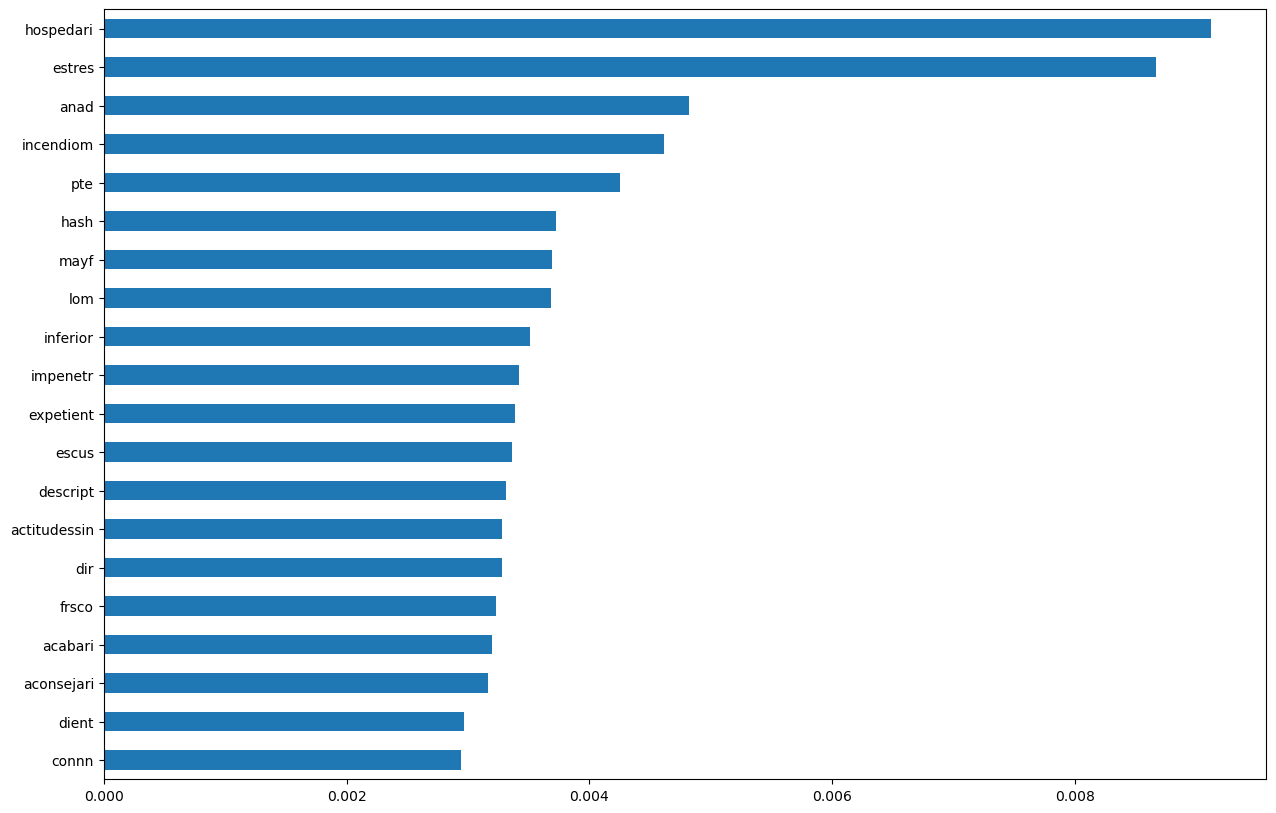

In [130]:
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))


In [131]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 267.94


In [132]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["Review"]))

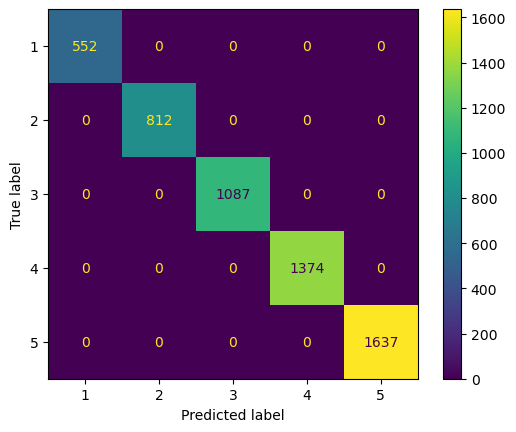

In [133]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

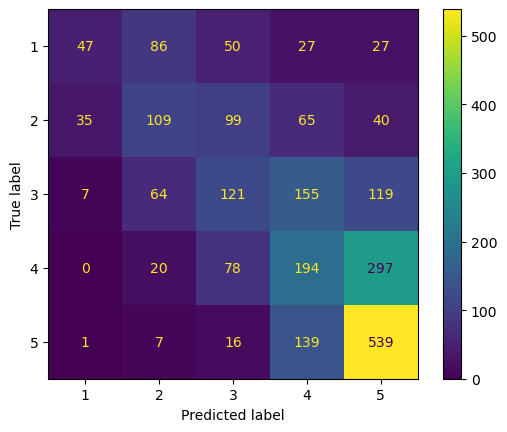

In [134]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [135]:
print(PRINT_PRECISION, precision_score(y_train, y_train_bow_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_bow_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_bow_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [136]:
print(PRINT_PRECISION, precision_score(y_test, y_test_bow_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_test, y_test_bow_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_bow_predict, average="weighted"))

Precision: 0.41782487286188974
Recall: 0.43125533731853116
F1: 0.40909684305144745
